# Baseline Gender Bias Document Classifiers

* **Supervised learning**
    * Train, Validate, and (Blind) Test Data: under directory `clf_data/`
* **Multilabel classification**
    * 3 categories of labels:
        1. *Person Name:* Unknown, Non-binary, Feminine, Masculine
        2. *Linguistic:* Generalization, Gendered Pronoun, Gendered Role
        3. *Contextual:* Empowering, Occupation, Omission, Stereotype

***

**Table of Contents**

[Setup](#set)

[Classifier 1: Multinomial Naive Bayes](#mnb)

[Classifier 2: Logistic Regression](#log) - top-performing

[Classifier 3: Random Forest](#ran) - worst-performing

***

<a id="set"></a>
## Setup

In [1]:
# For custom functions
import utils

# For working with data files and directories
import numpy as np
import pandas as pd
from pathlib import Path

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For classification with scikit-learn
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
# from sklearn.svm import SVC
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.tree import export_text
# from sklearn import tree
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support

Read in the training, validation, (a.k.a. development or devtest) and blind test data:

In [2]:
datadir = "clf_data/"
X_train_path = datadir+"train_docs.txt"
X_devtest_path = datadir+"validate_docs.txt"
X_blindtest_path = datadir+"blindtest_docs.txt"
y_train_path = datadir+"train_labels.txt"
y_devtest_path = datadir+"validate_labels.txt"
y_blindtest_path = datadir+"blindtest_labels.txt"

In [3]:
docs_seperator = "\n|\n"
labels_seperator = "\n"

In [4]:
X_train = utils.readData(X_train_path, docs_seperator)
print(X_train[0])
print(len(X_train))

This paper was published as a chapter in A Companion to Genethics, ed. J. Burley and J. Harris (Wiley-Blackwell, 2002).
7046


In [5]:
X_devtest = utils.readData(X_devtest_path, docs_seperator)
print(X_devtest[0])
print(len(X_devtest))

Peter Baillie ( 1889-1914), youngest brother to John Baillie and Donald Macpherson Baillie, was educated at Inverness Royal Academy and then at George Watson's College. Entering Edinburgh University in 1907, he graduated with a M.B., Ch.B. in 1912. For many years he was a member of the Philomathic Society and became its President in 1911. He was senior house surgeon at Mildmay Mission Hospital, London, for six months and in January 1914 he left Britain for Jalna, India, taking up a post to which he had been appointed by the Foreign Mission Committee of the United Free Church. He was ordained as a missionary elder of Langside Hill United Free Church, Glasgow, prior to his departure. While in India he was the victim of a drowning at Mahableshwar.
2350


In [6]:
y_train = utils.readData(y_train_path, labels_seperator)
print(y_train[:3])
print(len(y_train))

['Unknown, Occupation' 'Unknown, Occupation' 'Unknown']
7046


In [7]:
y_devtest = utils.readData(y_devtest_path, labels_seperator)
print(y_devtest[:3])
print(len(y_devtest))

['Generalization, Masculine, Gendered-Pronoun, Occupation, Gendered-Role, Unknown'
 'Omission, Feminine, Gendered-Pronoun, Occupation, Gendered-Role, Unknown, Stereotype'
 'Generalization, Masculine, Gendered-Pronoun, Occupation, Stereotype']
2350


In [8]:
X_blindtest = utils.readData(X_blindtest_path, docs_seperator)
y_blindtest = utils.readData(y_blindtest_path, labels_seperator)
assert len(X_blindtest) == len(y_blindtest), "There should be one group of labels for every document."

Convert the data to numeric representations, where:
```
labels = {
    "Unknown": 0, "Non-binary": 1, "Feminine": 2, "Masculine": 3,
    "Generalization": 4, "Gendered-Pronoun": 5, "Gendered-Role": 6,
    "Occupation": 7, "Omission":8, "Stereotype": 9, "Empowering": 10
         }
```

In [9]:
# Convert the strings of labels to tuples of numbers
y_train_numeric = utils.getNumericLabels(y_train)
y_devtest_numeric = utils.getNumericLabels(y_devtest)
y_blindtest_numeric = utils.getNumericLabels(y_blindtest)
assert len(y_train_numeric) == len(y_train)
assert len(y_devtest_numeric) == len(y_devtest)
assert len(y_blindtest_numeric) == len(y_blindtest)

In [10]:
# Convert each iterable of iterables above to a multilabel format
mlb = MultiLabelBinarizer()
y_train_binarized = mlb.fit_transform(y_train_numeric)
y_devtest_binarized = mlb.fit_transform(y_devtest_numeric)
y_blindtest_binarized = mlb.fit_transform(y_blindtest_numeric)
print(y_blindtest_binarized.shape)
print(y_blindtest_binarized[0])

(2352, 9)
[0 0 1 0 1 0 0 0 0]


In [11]:
# # Bag of Words
# count_vect = CountVectorizer()
# X_train_counts = count_vect.fit_transform(X_train)
# X_test_counts = count_vect.fit_transform(X_test)
# print("Bag of Words:")
# print(X_train_counts.shape)
# print(X_test_counts.shape)

# # Term Frequency times Inverse Document Frequency
# tfidf_transformer = TfidfTransformer()
# X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
# X_test_tfidf = tfidf_transformer.fit_transform(X_test_counts)
# print("TFIDF:")
# print(X_train_tfidf.shape)
# print(X_test_tfidf.shape)

In [12]:
# assert X_train_counts.shape[0] == len(y_train_numeric)
# assert X_test_tfidf.shape[0] == len(y_test_numeric)

Create the directory to write the classification models' performance metrics to:

In [50]:
metrics_dir = "./baseline_performance_metrics/"
Path(metrics_dir).mkdir(parents=True, exist_ok=True)

<a id="mnb"></a>
## Classifier 1: Multinomial Naive Bayes

Build a pipeline:

In [14]:
clf_pipeline = Pipeline([
    ("vect", CountVectorizer()),
    ("tfidf", TfidfTransformer()),
    ("clf", OneVsRestClassifier(MultinomialNB()))
    ])

In [15]:
clf_pipeline.fit(X_train, y_train_binarized)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 OneVsRestClassifier(estimator=MultinomialNB(alpha=1.0,
                                                             class_prior=None,
  

In [16]:
predicted_dev = clf_pipeline.predict(X_devtest)
predicted_test = clf_pipeline.predict(X_blindtest)

### Peformance

Calculate performance metrics for the Multinomial Naive Bayes classifier

In [17]:
print("Dev Test Accuracy:", np.mean(predicted_dev == y_devtest_binarized))
print("Blind Test Accuracy:", np.mean(predicted_test == y_blindtest_binarized))

Dev Test Accuracy: 0.8775886524822695
Blind Test Accuracy: 0.873630007558579


Reassuringly, there doesn't seem to be much difference between the accuracy of the model on the devtest and blindtest data.

In [18]:
classes = clf_pipeline.classes_
print(classes)
original_classes = mlb.classes_
print(original_classes)

[0 1 2 3 4 5 6 7 8]
[0 2 3 4 5 6 7 8 9]


Plot a [confusion matrix](https://scikit-learn.org/stable/modules/model_evaluation.html#multilabel-confusion-matrix) of the results, where, for class *i*:
* Count of true negatives (TN) is at position *i*,0,0
* Count of false negatives (FN) is at position *i*,1,0
* Count of true positives (FP) is at position *i*,1,1
* Count of false positives (PF) is at position *i*,0,1

In [19]:
dev_matrix = multilabel_confusion_matrix(y_devtest_binarized, predicted_dev, labels=classes)
df_dev = utils.getPerformanceMetrics(y_devtest_binarized, predicted_dev, dev_matrix, classes, original_classes)
df_dev

,labels,true_neg,false_neg,true_pos,false_pos,precision,recall,f_1
0,Unknown,239,39,1737,335,0.838320,0.978041,0.902807
1,Feminine,2234,115,1,0,1.000000,0.008621,0.017094
2,Masculine,1793,226,292,39,0.882175,0.563707,0.687868
3,Generalization,2083,267,0,0,0.000000,0.000000,0.000000
4,Gendered-Pronoun,2107,236,5,2,0.714286,0.020747,0.040323
5,Gendered-Role,1969,369,12,0,1.000000,0.031496,0.061069
6,Occupation,1981,350,19,0,1.000000,0.051491,0.097938
7,Omission,1472,296,455,127,0.781787,0.605859,0.682671
8,Stereotype,2057,186,105,2,0.981308,0.360825,0.527638


In [20]:
test_matrix = multilabel_confusion_matrix(y_blindtest_binarized, predicted_test, labels=classes)
df_test = utils.getPerformanceMetrics(y_blindtest_binarized, predicted_test, test_matrix, classes, original_classes)
df_test

,labels,true_neg,false_neg,true_pos,false_pos,precision,recall,f_1
0,Unknown,253,33,1761,305,0.852372,0.981605,0.912435
1,Feminine,2224,128,0,0,0.000000,0.000000,0.000000
2,Masculine,1783,265,258,46,0.848684,0.493308,0.623942
3,Generalization,2067,285,0,0,0.000000,0.000000,0.000000
4,Gendered-Pronoun,2104,240,8,0,1.000000,0.032258,0.062500
5,Gendered-Role,1990,354,8,0,1.000000,0.022099,0.043243
6,Occupation,1992,335,25,0,1.000000,0.069444,0.129870
7,Omission,1410,344,463,135,0.774247,0.573730,0.659075
8,Stereotype,2042,202,105,3,0.972222,0.342020,0.506024


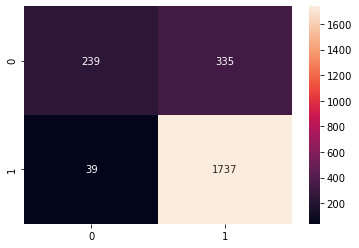

In [21]:
ax = sns.heatmap(dev_matrix[0], annot=True, fmt="d")

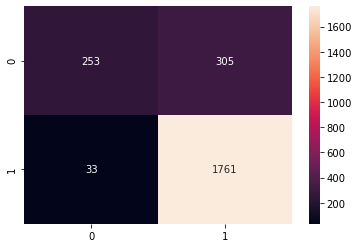

In [22]:
ax = sns.heatmap(test_matrix[0], annot=True, fmt="d")

In [23]:
df_dev.to_csv(metrics_dir+"MultinomialNB_dev_performance.csv")
df_test.to_csv(metrics_dir+"MultinomialNB_test_performance.csv")

<a id="log"></a>
## Classifier 2: Logistic Regression

*a.k.a. maximum-entropy (MaxEnt) or log-linear classification*

In [24]:
clf_pipeline = Pipeline([
    ("vect", CountVectorizer()),
    ("tfidf", TfidfTransformer()),
    ("clf", OneVsRestClassifier(LogisticRegression(solver="liblinear", multi_class="ovr")))
    ])

In [29]:
clf_pipeline.fit(X_train, y_train_binarized)
predicted_dev = clf_pipeline.predict(X_devtest)
predicted_test = clf_pipeline.predict(X_blindtest)

### Performance

Calculate performance metrics for the Logistic Regression classifier

In [30]:
print("Dev Test Accuracy:", np.mean(predicted_dev == y_devtest_binarized))
print("Blind Test Accuracy:", np.mean(predicted_test == y_blindtest_binarized))

Accuracy: 0.9130023640661938
Accuracy: 0.907785336356765


In [31]:
classes = clf_pipeline.classes_
original_classes = mlb.classes_

In [33]:
dev_matrix = multilabel_confusion_matrix(y_devtest_binarized, predicted_dev, labels=classes)
test_matrix = multilabel_confusion_matrix(y_blindtest_binarized, predicted_test, labels=classes)

In [36]:
df_dev = utils.getPerformanceMetrics(y_devtest_binarized, predicted_dev, dev_matrix, classes, original_classes)
df_dev

,labels,true_neg,false_neg,true_pos,false_pos,precision,recall,f_1
0,Unknown,266,37,1739,308,0.849536,0.979167,0.909757
1,Feminine,2232,88,28,2,0.933333,0.241379,0.383562
2,Masculine,1782,127,391,50,0.886621,0.754826,0.815433
3,Generalization,2066,153,114,17,0.870229,0.426966,0.572864
4,Gendered-Pronoun,2100,101,140,9,0.939597,0.580913,0.717949
5,Gendered-Role,1951,186,195,18,0.915493,0.511811,0.656566
6,Occupation,1966,235,134,15,0.899329,0.363144,0.517375
7,Omission,1481,274,477,118,0.801681,0.635153,0.708767
8,Stereotype,2035,78,213,24,0.898734,0.731959,0.806818


In [37]:
df_test = utils.getPerformanceMetrics(y_blindtest_binarized, predicted_test, test_matrix, classes, original_classes)
df_test

,labels,true_neg,false_neg,true_pos,false_pos,precision,recall,f_1
0,Unknown,273,36,1758,285,0.860499,0.979933,0.916341
1,Feminine,2221,99,29,3,0.906250,0.226562,0.362500
2,Masculine,1763,146,377,66,0.851016,0.720841,0.780538
3,Generalization,2056,162,123,11,0.917910,0.431579,0.587112
4,Gendered-Pronoun,2096,112,136,8,0.944444,0.548387,0.693878
5,Gendered-Role,1975,170,192,15,0.927536,0.530387,0.674868
6,Occupation,1963,231,129,29,0.816456,0.358333,0.498069
7,Omission,1411,323,484,134,0.783172,0.599752,0.679298
8,Stereotype,2021,98,209,24,0.896996,0.680782,0.774074


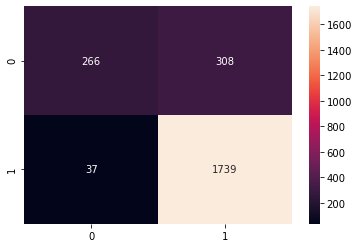

In [34]:
ax = sns.heatmap(dev_matrix[0], annot=True, fmt="d")

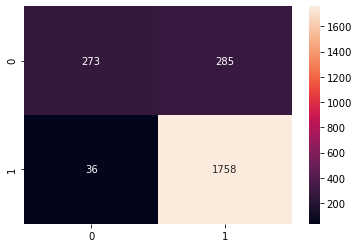

In [35]:
ax = sns.heatmap(test_matrix[0], annot=True, fmt="d")

In [129]:
# # Plot one matrix for each label
# matrices = dict()  # keys are labels, values are 2D arrays 
# for col in range(len(classes)):
#     y_test_label = y_test_binarized[:, col]
#     pred_label = predicted[:, col]
    
#     matrices[classes[col]] = confusion_matrix(pred_label, y_test_label, normalize="all")

# # Associate classes to numeric labels to strings of label names
# label_class_to_no = dict(zip(classes,original_classes))
# label_no_to_name = dict(zip(list(labels.values()), list(labels.keys())))

Write the confusion matrices to a file:

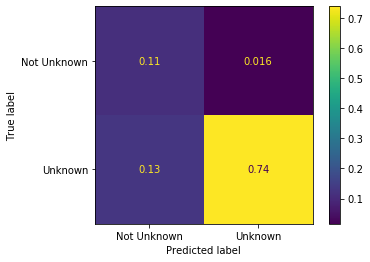

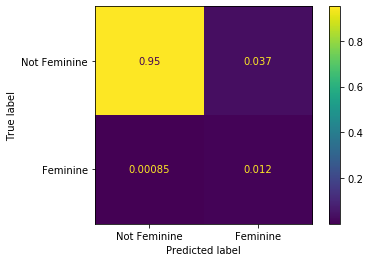

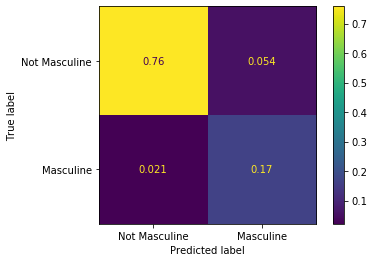

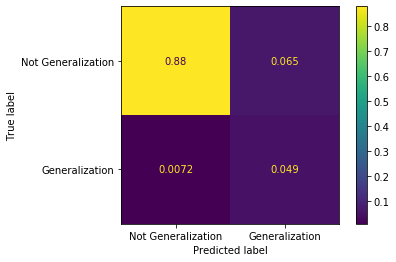

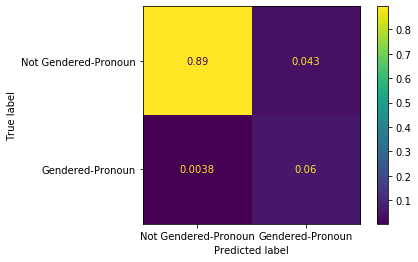

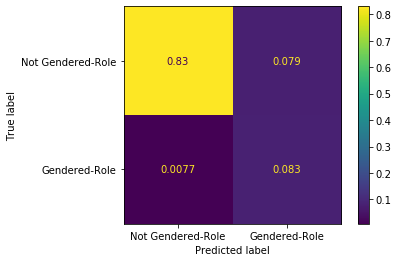

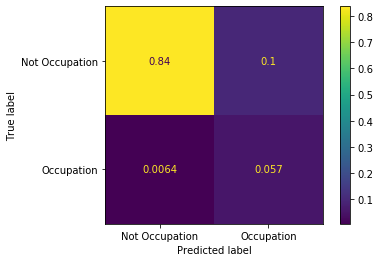

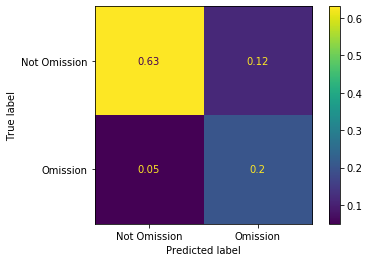

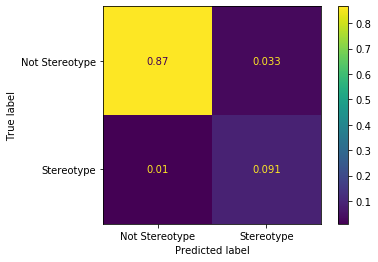

In [128]:
# png_dir = "ClfPerformanceMetrics/ConfusionMatrices/"
# for label_class,matrix in matrices.items():
#     label_name = label_no_to_name[label_class_to_no[label_class]]
#     filename = "{}_logreg_cmatrix_normalized_all.png".format(label_name)
#     ConfusionMatrixDisplay(matrix, display_labels=["Not "+label_name,label_name]).plot()
#     plt.savefig(png_dir+filename)

This classifier performs better than the first classifier (Multinomial Naive Bayes) and third classifier (Random Forest).

In [38]:
df_dev.to_csv(metrics_dir+"LogisticRegression_dev_performance.csv")
df_test.to_csv(metrics_dir+"LogisticRegression_test_performance.csv")

<a id="ran"></a>
## Classifier 3: Random Forest

In [39]:
clf_pipeline = Pipeline([
    ("vect", CountVectorizer()),
    ("tfidf", TfidfTransformer()),
    ("clf", OneVsRestClassifier(RandomForestClassifier(max_depth=3, random_state=0)))
    ])

In [40]:
clf_pipeline.fit(X_train, y_train_binarized)
predicted_dev = clf_pipeline.predict(X_devtest)
predicted_test = clf_pipeline.predict(X_blindtest)

In [41]:
classes = clf_pipeline.classes_
original_classes = mlb.classes_

In [42]:
print("Dev Test Accuracy:", np.mean(predicted_dev == y_devtest_binarized))
print("Blind Test Accuracy:", np.mean(predicted_test == y_blindtest_binarized))

Dev Test Accuracy: 0.8349881796690307
Blind Test Accuracy: 0.8318216175359032


In [47]:
dev_matrix = multilabel_confusion_matrix(y_devtest_binarized, predicted_dev, labels=classes)
df_dev = utils.getPerformanceMetrics(y_devtest_binarized, predicted_dev, dev_matrix, classes, original_classes)
df_dev

,labels,true_neg,false_neg,true_pos,false_pos,precision,recall,f_1
0,Unknown,0,0,1776,574,0.755745,1.000000,0.860882
1,Feminine,2234,116,0,0,0.000000,0.000000,0.000000
2,Masculine,1831,507,11,1,0.916667,0.021236,0.041509
3,Generalization,2083,267,0,0,0.000000,0.000000,0.000000
4,Gendered-Pronoun,2109,240,1,0,1.000000,0.004149,0.008264
5,Gendered-Role,1969,381,0,0,0.000000,0.000000,0.000000
6,Occupation,1981,364,5,0,1.000000,0.013550,0.026738
7,Omission,1597,747,4,2,0.666667,0.005326,0.010568
8,Stereotype,2059,291,0,0,0.000000,0.000000,0.000000


In [48]:
test_matrix = multilabel_confusion_matrix(y_blindtest_binarized, predicted_test, labels=classes)
df_test = utils.getPerformanceMetrics(y_blindtest_binarized, predicted_test, test_matrix, classes, original_classes)
df_test

,labels,true_neg,false_neg,true_pos,false_pos,precision,recall,f_1
0,Unknown,0,0,1794,558,0.762755,1.000000,0.865412
1,Feminine,2224,127,1,0,1.000000,0.007812,0.015504
2,Masculine,1828,514,9,1,0.900000,0.017208,0.033771
3,Generalization,2067,285,0,0,0.000000,0.000000,0.000000
4,Gendered-Pronoun,2104,247,1,0,1.000000,0.004032,0.008032
5,Gendered-Role,1990,361,1,0,1.000000,0.002762,0.005510
6,Occupation,1992,355,5,0,1.000000,0.013889,0.027397
7,Omission,1543,803,4,2,0.666667,0.004957,0.009840
8,Stereotype,2045,307,0,0,0.000000,0.000000,0.000000


This classifier performs worse than the other two.

In [51]:
df_dev.to_csv(metrics_dir+"RandomForest_dev_performance.csv")
df_test.to_csv(metrics_dir+"RandomForest_test_performance.csv")